In [7]:
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    # specify the path of the folder containing "file_name" :
    path_to_file = '/content/gdrive/My Drive/BT5153_2022_codes/codes/week8_nlp/'
    print(path_to_file)
    # change current path to the folder containing "file_name"
    os.chdir(path_to_file)
    !pwd

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/BT5153_2022_codes/codes/week8_nlp/
/content/gdrive/My Drive/BT5153_2022_codes/codes/week8_nlp


In [8]:
!ls

 Contextualized_Word_Embedding_from_BERT.ipynb
 data
 Deceptive_Opinion_Detection_using_BERT_without_Fine_Tune.ipynb
 Extraction_based_Question_Answering_using_BERT.ipynb
'Neural Network for Deceptive Opinion Detection via Keras.ipynb'
 text_preprocess.ipynb
 word2vec_gensim.ipynb


# Word2Vec Implemented on Gensim

## Learn word vectors from F.R.I.E.N.D.S.

Originally developed as a collection of python scripts implementing latent semantic methods, Gensim has developed into an world-class NLP resource. Now, it is a leading and a state-of-the-art package for processing texts, working with word vector models (such as Word2Vec, FastText etc) and for building topic models.

## Agenda

1. Prepare Corpus
2. Text Cleaning
3. Word2Vec Training
4. Explore the learned word vectors

In [9]:
import re  
import pandas as pd 
from collections import defaultdict  # For word frequency
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

### Part 1: Prepare Corpus

**Corpus**:

Here, we will look at the transcripts from F.R.I.E.N.D.S. It is because I love watching Friends and also the data is already prepared by someone (credit: [Shilpi Bhattacharyya](https://towardsdatascience.com/now-we-have-tv-sitcom-f-r-i-e-n-d-s-dataset-created-from-web-transcripts-908af7777977)
).

![alt text](https://github.com/rz0718/colab_imgs/blob/main/imgs/friends.jpg?raw=true)


    

This dataset contains the speaker, location, scene, season number and text i.e. script lines covering the 10 seasons. Here, we keep only one column: **Text**.

In [10]:
df = pd.read_csv('data//friends_dataset.csv', index_col=None)
df.head(3)

,Unnamed: 0,Location,Scene,Season,Speaker,Text
0,0,Chandler and Joey's,Joey is repacking the furniture into boxes to...,4,Joey,What?
1,1,Monica and Rachel's,"the next morning, Monica is getting the door,",1,Monica,"Oh, you got the whole night, huh?"
2,2,Mike's apartment,His phone rings and he picks up,9,Chandler,"Phoebe is going to say ""yes""? That's, that's g..."


In [11]:
df = df[['Text']]

### Part 2: Text Clean

For each line of dialogue, we will remove stop-words, non-alphbetic characters and conver all of them to lower-case.

#### Regarding Stop words:
https://kavita-ganesan.com/what-are-stop-words/#.XlZv5pMzbYU

https://www.quora.com/Is-it-compulsory-to-remove-stop-words-with-word2vec

In [12]:
brief_cleaning = lambda x: re.sub("[^A-Za-z']+", ' ', str(x)).lower()

In [15]:
df["clean"] = df.Text.apply(brief_cleaning)
from nltk.corpus import stopwords
import nltk 
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 
def cleaning(doc):
    # very simple tokenizer
    txt =doc.strip().split()
    txt = [word for word in txt if word not in stop_words]
    # remove the short sentence, since the context information is not enough
    if len(txt) > 2:
        return ' '.join(txt)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
# remove the short line
txt = [cleaning(doc) for doc in df.clean.values]
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(27047, 1)

#### Build Bigrams:
We are using Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences. https://radimrehurek.com/gensim/models/phrases.html

The main reason we do this is to catch words like "rachel_green" or "break_up" ! We will regard those detected phrase as a single word, which will improve the quality of the learned embeddings. 

In [35]:
!pip install gensim==3.6.0 -q

In [18]:
from gensim.models.phrases import Phrases, Phraser
# take a list of list of words as input
sent = [row.split() for row in df_clean['clean']]
phrases = Phrases(sent, min_count=10, progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[sent]

INFO - 17:28:14: collecting all words and their counts
INFO - 17:28:14: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 17:28:14: PROGRESS: at sentence #10000, processed 70067 words and 50342 word types
INFO - 17:28:14: PROGRESS: at sentence #20000, processed 141347 words and 88437 word types
INFO - 17:28:14: collected 111960 word types from a corpus of 191459 words (unigram + bigrams) and 27047 sentences
INFO - 17:28:14: using 111960 counts as vocab in Phrases<0 vocab, min_count=10, threshold=10.0, max_vocab_size=40000000>
INFO - 17:28:14: source_vocab length 111960
INFO - 17:28:15: Phraser built with 137 phrasegrams


In [19]:
# check the extracted bigram. Take phoebe_buffay as an example
for idx in range(len(sentences)):
    if "phoebe_buffay" in sentences[idx]:
        print("before bigram extracting")
        print(sent[idx])
        print("after bigram extracting")
        print(sentences[idx])
        break

before bigram extracting
['yeah', "i'm", 'phoebe', 'buffay', 'hannigan', 'banana', 'hammock']
after bigram extracting
['yeah', "i'm", 'phoebe_buffay', 'hannigan', 'banana', 'hammock']


#### Most Frequent Words
check the effectivenss of the above text preprocessing

In [20]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

12086

In [21]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['oh', 'know', 'okay', 'well', 'yeah', 'right', 'like', 'gonna', 'hey', 'get']

### Part 3: Word2Vec Training

We use Gensim implementation of word2vec: https://radimrehurek.com/gensim/models/word2vec.html

Word2vec's training in gensim can be generally decomposed into three steps: 

1. Word2Vec():

>In this first step, I set up the hyper-parameters of the model one-by-one. The corpus will not be provided at this step.


2. .build_vocab():

>Here it builds the vocabulary from a sequence of sentences and thus initialized the model.
With the loggings, the effect of the pre-defined hyper-parameters in step 1 such as min_count and sample on the word corpus can be monitored. The whole process will be displayed here for a double-check of these hyperparmaters' influence.


3. .train():

>Finally, the model is trained and word vectors are updated. The loggings here are mainly useful for monitoring, making sure that no threads are executed instantaneously.

In [22]:
# gensim support multi-core training
import multiprocessing
cores = multiprocessing.cpu_count()
from gensim.models import Word2Vec

#### Doc for hyperpameters in word2vec:

* min_count = int - Ignores all words with total absolute frequency lower than this - (2, 100)

* window = int - The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)

* size = int - Dimensionality of the feature vectors. - (50, 300)

* sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)

* alpha = float - The initial learning rate - (0.01, 0.05)

* min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00

* negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20). Here, in slides, we mentioned that to overcome the heavy softmax layer computation issue, negative sampling is one of the two approaches.

* workers = int - Use these many worker threads to train the model (=faster training with multicore machines)

In [23]:
w2v_model = Word2Vec(min_count=10,
                     window=3,
                     size=55,
                     sample=6e-5, 
                     alpha=0.05, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

WARNING - 17:28:41: consider setting layer size to a multiple of 4 for greater performance


#### Building the Vocabulary:

Word2Vec requires us to build the vocabulary table (simply digesting all the words and filtering out the unique words, and doing some basic counts on them) based on the hyperparameters set in the previous step.

In [24]:
w2v_model.build_vocab(sentences, progress_per=10000)

INFO - 17:28:45: collecting all words and their counts
INFO - 17:28:45: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 17:28:45: PROGRESS: at sentence #10000, processed 68223 words, keeping 7423 word types
INFO - 17:28:46: PROGRESS: at sentence #20000, processed 137813 words, keeping 10533 word types
INFO - 17:28:46: collected 12086 word types from a corpus of 186679 raw words and 27047 sentences
INFO - 17:28:46: Loading a fresh vocabulary
INFO - 17:28:46: effective_min_count=10 retains 1990 unique words (16% of original 12086, drops 10096)
INFO - 17:28:46: effective_min_count=10 leaves 163795 word corpus (87% of original 186679, drops 22884)
INFO - 17:28:46: deleting the raw counts dictionary of 12086 items
INFO - 17:28:46: sample=6e-05 downsamples 959 most-common words
INFO - 17:28:46: downsampling leaves estimated 55919 word corpus (34.1% of prior 163795)
INFO - 17:28:46: estimated required memory for 1990 words and 55 dimensions: 1870600 bytes
INFO - 17:28

#### Training of the model:

Doc for hyperparameters:

* total_examples = int - Count of sentences;

* epochs = int - Number of iterations (epochs) over the corpus - [10, 20, 30]

In [25]:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=40, report_delay=1)

INFO - 17:28:48: training model with 1 workers on 1990 vocabulary and 55 features, using sg=0 hs=0 sample=6e-05 negative=20 window=3
INFO - 17:28:49: EPOCH 1 - PROGRESS: at 96.35% examples, 52631 words/s, in_qsize 1, out_qsize 0
INFO - 17:28:49: worker thread finished; awaiting finish of 0 more threads
INFO - 17:28:49: EPOCH - 1 : training on 186679 raw words (55957 effective words) took 1.0s, 53722 effective words/s
INFO - 17:28:50: worker thread finished; awaiting finish of 0 more threads
INFO - 17:28:50: EPOCH - 2 : training on 186679 raw words (55977 effective words) took 1.0s, 58611 effective words/s
INFO - 17:28:51: worker thread finished; awaiting finish of 0 more threads
INFO - 17:28:51: EPOCH - 3 : training on 186679 raw words (55729 effective words) took 1.0s, 57531 effective words/s
INFO - 17:28:51: worker thread finished; awaiting finish of 0 more threads
INFO - 17:28:51: EPOCH - 4 : training on 186679 raw words (56016 effective words) took 0.9s, 60261 effective words/s
INF

(2237224, 7467160)

In [ ]:
# we can save the model and load it again
w2v_model.save('tmp_model')
# new_model = gensim.models.Word2Vec.load('tmp_model')

In [26]:
# w2v_model.init_sims(replace=True)
w2v_model.init_sims(replace=True)

INFO - 17:29:31: precomputing L2-norms of word weight vectors


### Part 4: Explore the learned word2vec model

Gensim also provides lots of functions to manipulate word vectors. Let us check some of them

We can check what we will get for the main characters. Make fun with these learned word vectors.

#### Given a word, find its most Similar

#####  Look at similar words for joey

This is one of the main characters in Friends.

![alt text](https://github.com/rz0718/colab_imgs/blob/main/imgs/joey.jpeg?raw=true)

In [27]:
w2v_model.wv.most_similar(positive=["joey"])

[('chandler', 0.6862534880638123),
 ('chan', 0.6751699447631836),
 ('j', 0.5965216755867004),
 ('missy', 0.5914252400398254),
 ("what's_going", 0.5886914730072021),
 ('patch', 0.5832797884941101),
 ('rach', 0.580456018447876),
 ("what's_matter", 0.573567807674408),
 ('turning', 0.5676241517066956),
 ('bite', 0.5667166113853455)]

the score is the cosine value between two vectors.

Look like the model makes sense, since chandler and joey are best roommates.

And the second similar words "doin" is in his famous line: ``How You Doin``

![alt text](https://github.com/rz0718/colab_imgs/blob/main/imgs/joey_chan.jpeg?raw=true)

  Then, how about the bigram "joey tribbiani". It is the full name.

In [28]:
w2v_model.wv.most_similar(positive=["joey_tribbiani"])

[('introduce', 0.6457539796829224),
 ('hello', 0.6189807057380676),
 ('professor', 0.6134908199310303),
 ('stars', 0.6131969094276428),
 ('chandler_bing', 0.5953868627548218),
 ('nice_meet', 0.5893290042877197),
 ('days_lives', 0.5781505703926086),
 ("ross's", 0.5755629539489746),
 ('carl', 0.5751028656959534),
 ('remoray', 0.5750212073326111)]

This model returns more words related to Joey's job: actor. 

![alt text](https://github.com/rz0718/colab_imgs/blob/main/imgs/dlife.jpeg?raw=true)

#### Given a list of words, find the word that does not belong to the list.

How about friendship among these three girls?

In [29]:
w2v_model.wv.doesnt_match(['monica', 'rachel', 'phoebe'])

/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'phoebe'

#### Analogy difference:

Which word is to woman as ross is to man?

In [30]:
w2v_model.wv.most_similar(positive=["woman", "ross"], negative=["man"], topn=3)

[('rachel', 0.7211468815803528),
 ('marry', 0.575393557548523),
 ('happen', 0.5692956447601318)]



```
# This is formatted as code
```

Rachel is in the top1!!! Seems the result is not bad.

![alt txt](https://github.com/rz0718/colab_imgs/blob/main/imgs/love.jpeg?raw=true)

In [31]:
#### How to take word vectors out?

#We can also extract vectors from the w2v model and utilize them with other methods. 

vocabs = []
vecs = []
for word in w2v_model.wv.vocab:
    vocabs.append(word)
    vecs.append(w2v_model[word])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


#### Visualize these word embeddings

We can reduce the embeddings size to 2 by TSNE (non-linear dimensionality reduction method)

In [32]:
from sklearn.manifold import TSNE
sub_vecs = vecs[:100]
sub_vocab = vocabs[:100]
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2000, random_state=23)
new_values = tsne_model.fit_transform(sub_vecs)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


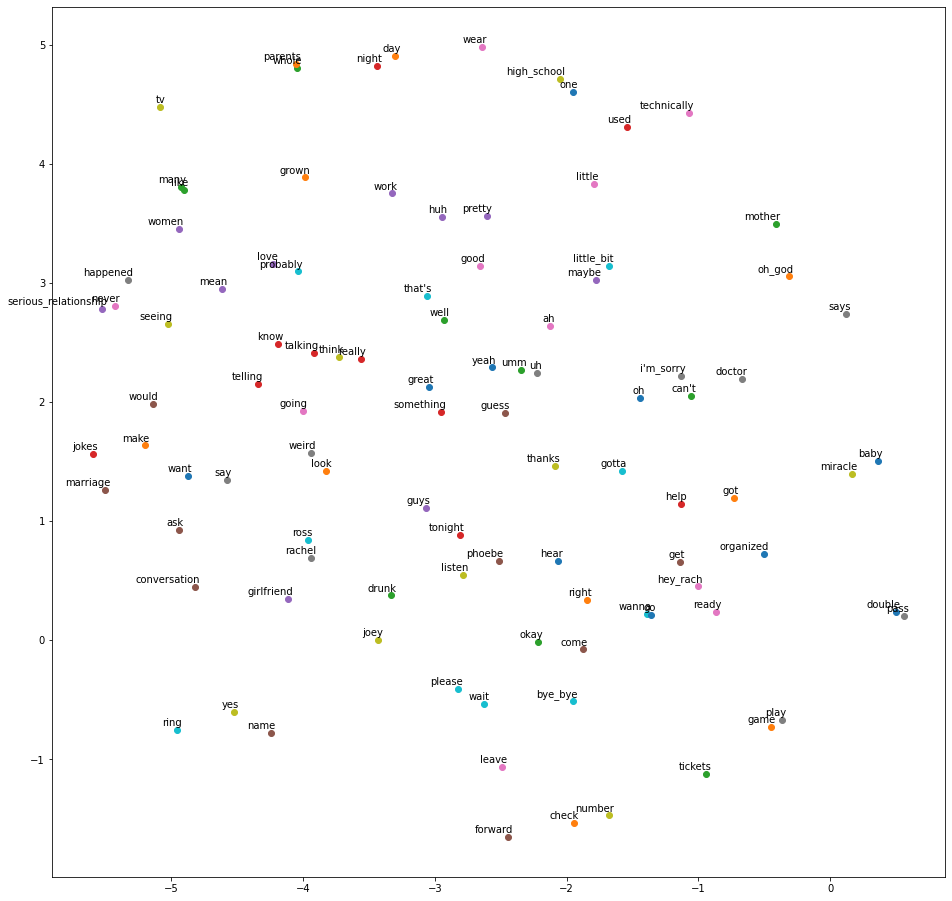

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
        
plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(sub_vocab[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
plt.show()

Other Tutorial about gensim:

http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W467ScBjM2x

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/